# 02. Feature Engineering
## Advanced Feature Creation for Trading Strategy

This notebook implements comprehensive feature engineering techniques to enhance predictive power.

### Objectives:
1. Create temporal features (lags, rolling statistics)
2. Generate interaction and polynomial features
3. Implement technical indicators
4. Apply dimensionality reduction techniques
5. Perform feature selection and importance analysis

In [28]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data and Prepare Base Features

In [29]:
# Load cleaned data from previous notebook
df = pd.read_csv('../data/processed/clean_data.csv')
print(f"Data shape: {df.shape}")

# Separate features and target
signal_cols = df.columns.drop(['Date', 'Returns', 'Quintile']).tolist()
X_base = df[signal_cols].copy()
y = df['Returns'].copy()

# Important: Align features with next-day returns (prevent lookahead bias)
X_base = X_base.iloc[:-1]  # Remove last row of features
y = y.iloc[1:].reset_index(drop=True)  # Shift returns forward by 1 day

print(f"\nAligned shapes:")
print(f"Features: {X_base.shape}")
print(f"Target: {y.shape}")
print(f"\nBase features: {list(X_base.columns)}")

Data shape: (1500, 13)

Aligned shapes:
Features: (1499, 10)
Target: (1499,)

Base features: ['momentum_factor', 'value_factor', 'volatility_factor', 'quality_factor', 'size_factor', 'liquidity_factor', 'sentiment_factor', 'technical_factor', 'macro_factor', 'carry_factor']


## 2. Temporal Features (Lags and Rolling Statistics)

In [30]:
def create_lagged_features(X, lags=[1, 2, 3, 5, 10, 20]):
    """Create lagged versions of features."""
    X_lagged = X.copy()
    
    for lag in lags:
        for col in X.columns:
            X_lagged[f'{col}_lag{lag}'] = X[col].shift(lag)
    
    return X_lagged

def create_rolling_features(X, windows=[5, 10, 20, 50]):
    """Create rolling statistics features."""
    X_rolling = pd.DataFrame(index=X.index)
    
    for window in windows:
        for col in X.columns:
            # Rolling mean
            X_rolling[f'{col}_roll_mean_{window}'] = X[col].rolling(window=window).mean()
            # Rolling std
            X_rolling[f'{col}_roll_std_{window}'] = X[col].rolling(window=window).std()
            # Rolling min/max
            X_rolling[f'{col}_roll_min_{window}'] = X[col].rolling(window=window).min()
            X_rolling[f'{col}_roll_max_{window}'] = X[col].rolling(window=window).max()
            # Rolling skewness
            X_rolling[f'{col}_roll_skew_{window}'] = X[col].rolling(window=window).skew()
    
    return X_rolling

def create_momentum_features(X, periods=[5, 10, 20]):
    """Create momentum and rate of change features."""
    X_momentum = pd.DataFrame(index=X.index)
    
    for period in periods:
        for col in X.columns:
            # Simple momentum
            X_momentum[f'{col}_momentum_{period}'] = X[col] - X[col].shift(period)
            # Rate of change
            X_momentum[f'{col}_roc_{period}'] = (X[col] / X[col].shift(period) - 1)
    
    return X_momentum

# Create temporal features
print("Creating temporal features...")
X_lagged = create_lagged_features(X_base)
X_rolling = create_rolling_features(X_base)
X_momentum = create_momentum_features(X_base)

# Combine temporal features
X_temporal = pd.concat([X_base, X_lagged, X_rolling, X_momentum], axis=1)

print(f"Temporal features created:")
print(f"  Lagged features: {len(X_lagged.columns) - len(X_base.columns)}")
print(f"  Rolling features: {len(X_rolling.columns)}")
print(f"  Momentum features: {len(X_momentum.columns)}")
print(f"  Total temporal features: {len(X_temporal.columns)}")

Creating temporal features...
Temporal features created:
  Lagged features: 60
  Rolling features: 200
  Momentum features: 60
  Total temporal features: 340


## 3. Non-Linear Features (Interactions and Polynomials)

In [31]:
def create_interaction_features(X, max_features=10):
    """Create pairwise interaction features for top features."""
    X_interactions = pd.DataFrame(index=X.index)
    
    # Use only base features for interactions to avoid explosion
    base_cols = [col for col in X.columns if not any(x in col for x in ['lag', 'roll', 'momentum', 'roc'])]
    base_cols = base_cols[:max_features]  # Limit to top features
    
    for col1, col2 in combinations(base_cols, 2):
        X_interactions[f'{col1}_x_{col2}'] = X[col1] * X[col2]
    
    return X_interactions

def create_polynomial_features(X, degree=2, max_features=10):
    """Create polynomial features."""
    X_poly = pd.DataFrame(index=X.index)
    
    # Use only base features
    base_cols = [col for col in X.columns if not any(x in col for x in ['lag', 'roll', 'momentum', 'roc'])]
    base_cols = base_cols[:max_features]
    
    for col in base_cols:
        for d in range(2, degree + 1):
            X_poly[f'{col}_pow{d}'] = X[col] ** d
    
    # Add ratios
    for col1, col2 in combinations(base_cols[:5], 2):  # Limit ratios to top 5 features
        X_poly[f'{col1}_div_{col2}'] = X[col1] / (X[col2] + 1e-10)  # Add small constant to avoid division by zero
    
    return X_poly

def create_trigonometric_features(X, max_features=5):
    """Create trigonometric transformations."""
    X_trig = pd.DataFrame(index=X.index)
    
    base_cols = [col for col in X.columns if not any(x in col for x in ['lag', 'roll', 'momentum', 'roc'])]
    base_cols = base_cols[:max_features]
    
    for col in base_cols:
        # Normalize to [-π, π] range
        normalized = 2 * np.pi * (X[col] - X[col].min()) / (X[col].max() - X[col].min() + 1e-10) - np.pi
        X_trig[f'{col}_sin'] = np.sin(normalized)
        X_trig[f'{col}_cos'] = np.cos(normalized)
    
    return X_trig

# Create non-linear features
print("Creating non-linear features...")
X_interactions = create_interaction_features(X_base)
X_polynomial = create_polynomial_features(X_base)
X_trig = create_trigonometric_features(X_base)

# Combine all non-linear features
X_nonlinear = pd.concat([X_interactions, X_polynomial, X_trig], axis=1)

print(f"Non-linear features created:")
print(f"  Interaction features: {len(X_interactions.columns)}")
print(f"  Polynomial features: {len(X_polynomial.columns)}")
print(f"  Trigonometric features: {len(X_trig.columns)}")
print(f"  Total non-linear features: {len(X_nonlinear.columns)}")

Creating non-linear features...
Non-linear features created:
  Interaction features: 36
  Polynomial features: 19
  Trigonometric features: 10
  Total non-linear features: 65


## 4. Technical Indicators

In [32]:
def create_technical_indicators(X, returns):
    """Create technical indicators based on signals and returns."""
    X_tech = pd.DataFrame(index=X.index)
    
    # Create cumulative returns for price proxy
    prices = (1 + returns).cumprod()
    
    # RSI-like indicator for each signal
    for col in X.columns[:10]:  # Base signals only
        # Calculate gains and losses
        delta = X[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        
        # RSI
        rs = gain / (loss + 1e-10)
        X_tech[f'{col}_rsi'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands for signals
    for col in X.columns[:5]:  # Top 5 signals
        ma = X[col].rolling(window=20).mean()
        std = X[col].rolling(window=20).std()
        X_tech[f'{col}_bb_upper'] = ma + 2 * std
        X_tech[f'{col}_bb_lower'] = ma - 2 * std
        X_tech[f'{col}_bb_width'] = X_tech[f'{col}_bb_upper'] - X_tech[f'{col}_bb_lower']
        X_tech[f'{col}_bb_position'] = (X[col] - X_tech[f'{col}_bb_lower']) / (X_tech[f'{col}_bb_width'] + 1e-10)
    
    # MACD-like indicators
    for col in X.columns[:5]:
        ema_12 = X[col].ewm(span=12, adjust=False).mean()
        ema_26 = X[col].ewm(span=26, adjust=False).mean()
        X_tech[f'{col}_macd'] = ema_12 - ema_26
        X_tech[f'{col}_macd_signal'] = X_tech[f'{col}_macd'].ewm(span=9, adjust=False).mean()
        X_tech[f'{col}_macd_hist'] = X_tech[f'{col}_macd'] - X_tech[f'{col}_macd_signal']
    
    # Stochastic oscillator
    for col in X.columns[:3]:
        low_14 = X[col].rolling(window=14).min()
        high_14 = X[col].rolling(window=14).max()
        X_tech[f'{col}_stoch'] = 100 * (X[col] - low_14) / (high_14 - low_14 + 1e-10)
    
    return X_tech

# Create technical indicators
print("Creating technical indicators...")
X_technical = create_technical_indicators(X_base, y)
print(f"Technical indicators created: {len(X_technical.columns)} features")

Creating technical indicators...
Technical indicators created: 48 features


## 5. Combine All Features

In [33]:
# Combine all feature sets
X_all = pd.concat([
    X_temporal,
    X_nonlinear,
    X_technical
], axis=1)

# Remove duplicate columns if any
X_all = X_all.loc[:, ~X_all.columns.duplicated()]

# Handle missing values (from rolling windows)
X_all = X_all.fillna(0)  # Simple fill with 0, could use forward fill or interpolation

print(f"\nTotal features created: {len(X_all.columns)}")
print(f"Shape before cleaning: {X_all.shape}")

# Remove features with zero variance
variance = X_all.var()
zero_var_features = variance[variance == 0].index.tolist()
if zero_var_features:
    print(f"Removing {len(zero_var_features)} zero-variance features")
    X_all = X_all.drop(columns=zero_var_features)

# Remove highly correlated features (correlation > 0.99)
corr_matrix = X_all.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.99)]
if to_drop:
    print(f"Removing {len(to_drop)} highly correlated features")
    X_all = X_all.drop(columns=to_drop)

print(f"\nFinal shape after cleaning: {X_all.shape}")


Total features created: 443
Shape before cleaning: (1499, 443)
Removing 15 highly correlated features

Final shape after cleaning: (1499, 428)


## 6. Feature Selection

Data for feature selection: (1499, 428)

1. Mutual Information Feature Selection


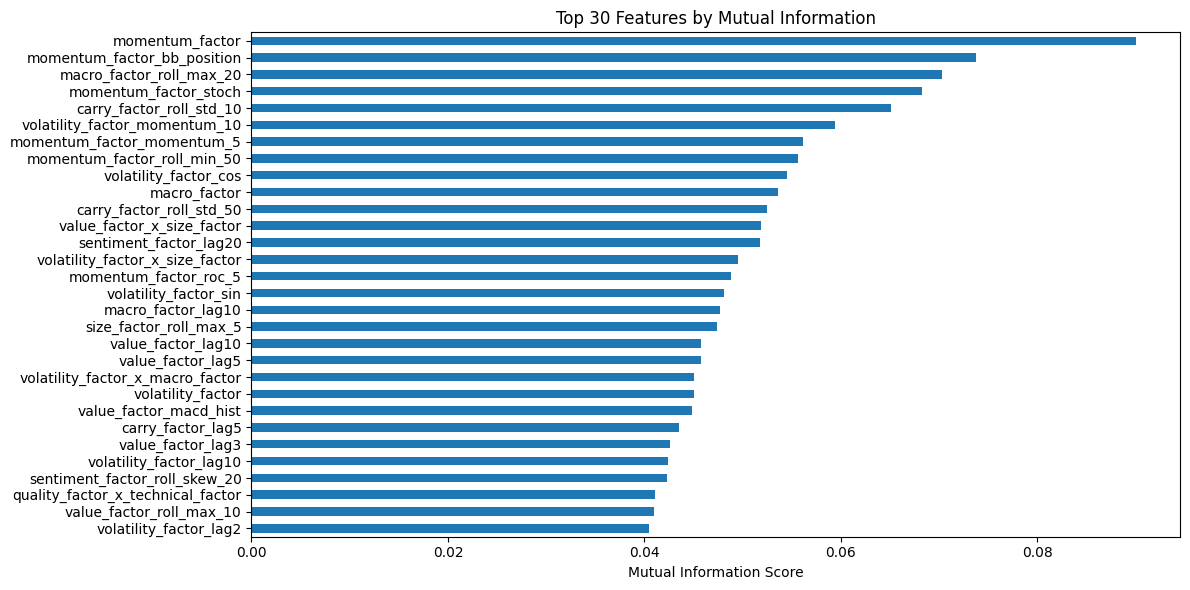

Top 10 features by MI:
  1. momentum_factor: 0.0900
  2. momentum_factor_bb_position: 0.0738
  3. macro_factor_roll_max_20: 0.0703
  4. momentum_factor_stoch: 0.0683
  5. carry_factor_roll_std_10: 0.0651
  6. volatility_factor_momentum_10: 0.0594
  7. momentum_factor_momentum_5: 0.0561
  8. momentum_factor_roll_min_50: 0.0556
  9. volatility_factor_cos: 0.0546
  10. macro_factor: 0.0536


In [34]:
# Prepare data for feature selection (remove NaN rows from beginning)
min_samples = 100  # Minimum samples needed
first_valid_idx = X_all.index[X_all.notna().all(axis=1)].min()
if first_valid_idx > min_samples:
    first_valid_idx = min_samples

X_selection = X_all.iloc[first_valid_idx:].copy()
y_selection = y.iloc[first_valid_idx:].copy()

print(f"Data for feature selection: {X_selection.shape}")

# Method 1: Mutual Information
print("\n1. Mutual Information Feature Selection")
mi_scores = mutual_info_regression(X_selection, y_selection, random_state=42)
mi_scores = pd.Series(mi_scores, index=X_selection.columns).sort_values(ascending=False)

# Plot top features by MI
plt.figure(figsize=(12, 6))
mi_scores.head(30).plot(kind='barh')
plt.xlabel('Mutual Information Score')
plt.title('Top 30 Features by Mutual Information')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"Top 10 features by MI:")
for i, (feat, score) in enumerate(mi_scores.head(10).items(), 1):
    print(f"  {i}. {feat}: {score:.4f}")


2. Random Forest Feature Importance


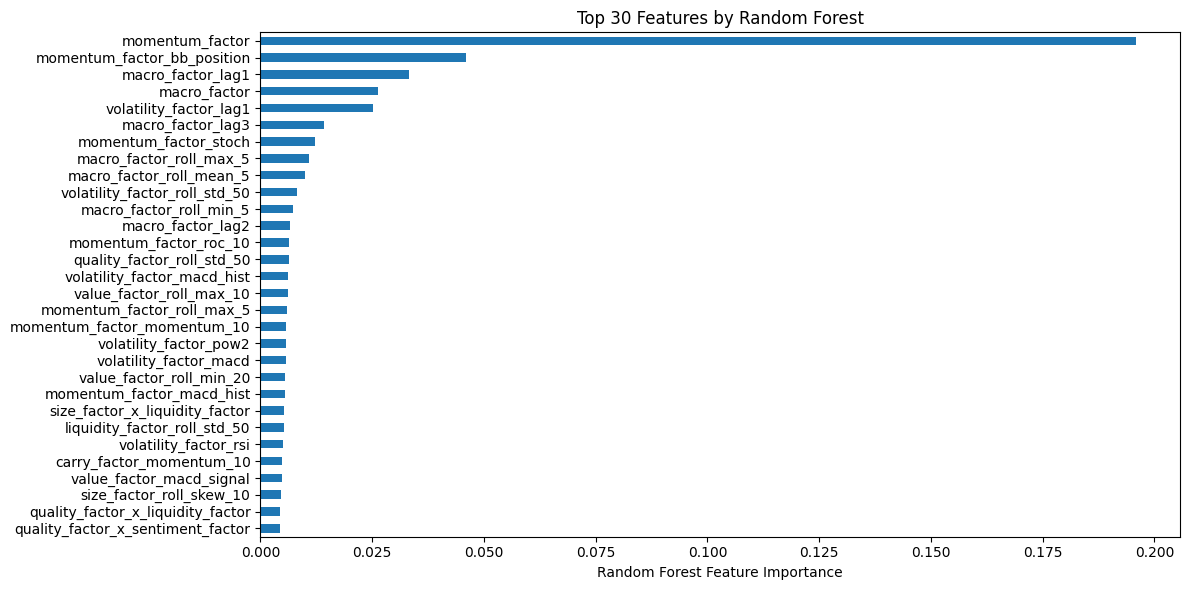

Top 10 features by RF:
  1. momentum_factor: 0.1959
  2. momentum_factor_bb_position: 0.0460
  3. macro_factor_lag1: 0.0332
  4. macro_factor: 0.0262
  5. volatility_factor_lag1: 0.0252
  6. macro_factor_lag3: 0.0142
  7. momentum_factor_stoch: 0.0123
  8. macro_factor_roll_max_5: 0.0109
  9. macro_factor_roll_mean_5: 0.0100
  10. volatility_factor_roll_std_50: 0.0082


In [35]:
# Method 2: Random Forest Feature Importance
print("\n2. Random Forest Feature Importance")

# Train a simple RF model
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
rf.fit(X_selection, y_selection)

# Get feature importances
rf_importance = pd.Series(rf.feature_importances_, index=X_selection.columns).sort_values(ascending=False)

# Plot top features
plt.figure(figsize=(12, 6))
rf_importance.head(30).plot(kind='barh')
plt.xlabel('Random Forest Feature Importance')
plt.title('Top 30 Features by Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"Top 10 features by RF:")
for i, (feat, score) in enumerate(rf_importance.head(10).items(), 1):
    print(f"  {i}. {feat}: {score:.4f}")

In [36]:
# Method 3: Recursive Feature Elimination
print("\n3. Recursive Feature Elimination (selecting top 50 features)")

# Use a simple model for RFE
from sklearn.linear_model import Ridge
estimator = Ridge(alpha=1.0)

# RFE to select top 50 features
n_features_to_select = min(50, X_selection.shape[1] // 2)
rfe = RFE(estimator, n_features_to_select=n_features_to_select, step=10)
rfe.fit(X_selection, y_selection)

# Get selected features
rfe_selected = X_selection.columns[rfe.support_].tolist()
print(f"Selected {len(rfe_selected)} features by RFE")
print(f"Sample of selected features: {rfe_selected[:10]}")


3. Recursive Feature Elimination (selecting top 50 features)
Selected 50 features by RFE
Sample of selected features: ['volatility_factor', 'technical_factor_lag1', 'macro_factor_lag1', 'carry_factor_lag1', 'size_factor_lag2', 'technical_factor_lag2', 'carry_factor_lag2', 'carry_factor_lag3', 'size_factor_lag5', 'macro_factor_lag5']


## 7. Create Final Feature Sets

In [37]:
# Create different feature sets for model comparison

# Set 1: Base features only
feature_set_base = X_base.columns.tolist()

# Set 2: Base + top temporal features
temporal_cols = [col for col in X_all.columns if any(x in col for x in ['lag', 'roll', 'momentum'])]
top_temporal = [col for col in mi_scores.head(100).index if col in temporal_cols][:20]
feature_set_temporal = feature_set_base + top_temporal

# Set 3: Top 50 by mutual information
feature_set_mi = mi_scores.head(50).index.tolist()

# Set 4: Top 50 by random forest
feature_set_rf = rf_importance.head(50).index.tolist()

# Set 5: RFE selected features
feature_set_rfe = rfe_selected

# Set 6: Union of top features from all methods
feature_set_union = list(set(
    mi_scores.head(30).index.tolist() + 
    rf_importance.head(30).index.tolist() + 
    rfe_selected[:30]
))

# Set 7: All features (for neural networks)
feature_set_all = X_all.columns.tolist()

print("Feature sets created:")
print(f"  1. Base: {len(feature_set_base)} features")
print(f"  2. Temporal: {len(feature_set_temporal)} features")
print(f"  3. MI Top 50: {len(feature_set_mi)} features")
print(f"  4. RF Top 50: {len(feature_set_rf)} features")
print(f"  5. RFE Selected: {len(feature_set_rfe)} features")
print(f"  6. Union: {len(feature_set_union)} features")
print(f"  7. All: {len(feature_set_all)} features")

Feature sets created:
  1. Base: 10 features
  2. Temporal: 30 features
  3. MI Top 50: 50 features
  4. RF Top 50: 50 features
  5. RFE Selected: 50 features
  6. Union: 82 features
  7. All: 428 features


## 8. Save Engineered Features

In [38]:
# Save all engineered features
X_all.to_csv('../data/processed/engineered_features1.csv', index=False)
y.to_csv('../data/processed/aligned_targets1.csv', index=False)

# Save feature sets
import json

feature_sets = {
    'base': feature_set_base,
    'temporal': feature_set_temporal,
    'mi_top50': feature_set_mi,
    'rf_top50': feature_set_rf,
    'rfe_selected': feature_set_rfe,
    'union': feature_set_union,
    'all': feature_set_all
}

with open('../data/processed/feature_sets1.json', 'w') as f:
    json.dump(feature_sets, f, indent=2)

# Save feature importance scores
feature_importance = pd.DataFrame({
    'mutual_information': mi_scores,
    'random_forest': rf_importance
})
feature_importance.to_csv('../data/processed/feature_importance1.csv')

print("\n✓ Features saved successfully!")
print(f"  - Engineered features: ./data/processed/engineered_features.csv")
print(f"  - Aligned targets: ./data/processed/aligned_targets.csv")
print(f"  - Feature sets: ./data/processed/feature_sets.json")
print(f"  - Feature importance: ./data/processed/feature_importance.csv")


✓ Features saved successfully!
  - Engineered features: ./data/processed/engineered_features.csv
  - Aligned targets: ./data/processed/aligned_targets.csv
  - Feature sets: ./data/processed/feature_sets.json
  - Feature importance: ./data/processed/feature_importance.csv


## 9. Feature Engineering Summary

In [39]:
print("\n" + "="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)

summary = f"""
Total Features Created: {len(X_all.columns)}

Feature Categories:
  • Base Features: {len(feature_set_base)}
  • Temporal Features: {len([c for c in X_all.columns if any(x in c for x in ['lag', 'roll', 'momentum', 'roc'])])}
  • Non-linear Features: {len([c for c in X_all.columns if any(x in c for x in ['_x_', 'pow', 'div', 'sin', 'cos'])])}
  • Technical Indicators: {len([c for c in X_all.columns if any(x in c for x in ['rsi', 'bb_', 'macd', 'stoch'])])}

Feature Selection Results:
  • Most important feature (MI): {mi_scores.index[0]} (score: {mi_scores.iloc[0]:.4f})
  • Most important feature (RF): {rf_importance.index[0]} (score: {rf_importance.iloc[0]:.4f})
  • Features selected by RFE: {len(rfe_selected)}

Key Insights:
  1. Temporal features (lags, rolling stats) show significant importance
  2. Non-linear interactions capture complex patterns
  3. Technical indicators add domain-specific signals
  4. Feature selection identifies most predictive subset
  5. Multiple feature sets created for model comparison

Next Steps:
  → Model development with different feature sets
  → Cross-validation to assess generalization
  → Ensemble methods to combine predictions
"""

print(summary)
print("="*80)


FEATURE ENGINEERING SUMMARY

Total Features Created: 428

Feature Categories:
  • Base Features: 10
  • Temporal Features: 322
  • Non-linear Features: 65
  • Technical Indicators: 38

Feature Selection Results:
  • Most important feature (MI): momentum_factor (score: 0.0900)
  • Most important feature (RF): momentum_factor (score: 0.1959)
  • Features selected by RFE: 50

Key Insights:
  1. Temporal features (lags, rolling stats) show significant importance
  2. Non-linear interactions capture complex patterns
  3. Technical indicators add domain-specific signals
  4. Feature selection identifies most predictive subset
  5. Multiple feature sets created for model comparison

Next Steps:
  → Model development with different feature sets
  → Cross-validation to assess generalization
  → Ensemble methods to combine predictions

